In [106]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

In [2]:
model_spec_name_list = ['cadrres', 'cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight']
output_dir = '../result/cv_pred/'
n_fold = 5

In [3]:
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
gdsc_drug_df.index = gdsc_drug_df.index.astype(str)

gdsc_drug_list = gdsc_drug_df.index

print (gdsc_drug_df.shape)

(81, 27)


In [28]:
gdsc_drug_id_name_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['Drug Name'].values))

In [29]:
selected_drug_ids = ['1032', '1007', '133', '201', '1010', '182', '301', '302', '1012']
selected_drug_names = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103', 'Vorinostat']

In [4]:
drug_log2_max_conc_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['log2_max_conc']))
drug_log2_median_ic50_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['log2_median_ic50']))

##### Read predictions

In [5]:
output_dict = {}

for model_spec_name in model_spec_name_list:
    
    output_dict[model_spec_name] = []
    
    for k in range(1, n_fold+1):
        pred_dict = pickle.load(open(output_dir + '{}_HNSC_5f_{}_output_dict.pickle'.format(model_spec_name, k), 'rb'))
        output_dict[model_spec_name].append(pred_dict)

# Compare obs and pred for all validation sets

### For each drug

In [6]:
from sklearn.metrics import f1_score, precision_score, accuracy_score

In [86]:
result_df_list = []

for model_spec_name in model_spec_name_list:
    for k in range(n_fold):
        
        pred_test_df = output_dict[model_spec_name][k]['pred_test_df']
        obs_test_df = output_dict[model_spec_name][k]['obs_test_df']
        
        pred_train_df = output_dict[model_spec_name][k]['pred_train_df']
        obs_train_df = output_dict[model_spec_name][k]['obs_train_df']
        
        drug_list = obs_train_df.columns
        
        results = []
        
        for i, d in enumerate(drug_list):
            
            x = obs_test_df[d].values
            y = pred_test_df[d].values
            sel = ~np.isnan(x)
            
            x = x[sel]
            y = y[sel]
            
            # spearman
            scor, pval = stats.spearmanr(x, y)
            
            # F1 weighted
            x_bool = (x < drug_log2_max_conc_dict[d]).astype(str)
            y_bool = (y < drug_log2_max_conc_dict[d]).astype(str)
            f1 = f1_score(x_bool, y_bool, average='weighted')
            acc = accuracy_score(x_bool, y_bool)
            
            precent_sensitive = (np.sum(x < drug_log2_max_conc_dict[d]) / len(x)) * 100
            
            if precent_sensitive > 0:
                (f1_resistant, f1_sensitive) = f1_score(x_bool, y_bool, average=None)
                (precision1_resistant, precision_sensitive) = precision_score(x_bool, y_bool, average=None)
            else:
                f1_resistant = np.nan
                f1_sensitive = np.nan
                precision1_resistant = np.nan
                precision_sensitive = np.nan
            
            # MAE (sensitive)
            sensitive_sel = x < drug_log2_max_conc_dict[d]
            x_sensitive = x[sensitive_sel]
            y_sensitive = y[sensitive_sel]
            mae = np.mean(np.abs(x_sensitive - y_sensitive))

            # MAE (capped)
            x_capped = np.minimum(x, np.repeat(drug_log2_max_conc_dict[d], len(x)))
            y_capped = np.minimum(y, np.repeat(drug_log2_max_conc_dict[d], len(y)))
            capped_mae = np.mean(np.abs(x_capped - y_capped))
            
            results += [[d, precent_sensitive, drug_log2_max_conc_dict[d], drug_log2_median_ic50_dict[d],
                         scor, pval, acc, f1, f1_resistant, f1_sensitive, precision1_resistant, precision_sensitive, mae, capped_mae]]
            
        result_df = pd.DataFrame(results, columns=['drug_id', 'precent_sensitive', 'log2_max_conc', 'log2_median_ic50', 'spearman', 'pval', 'accurary', 'F1_weighted', 'F1_resistant', 'F1_sensitive', 'precision1_resistant', 'precision_sensitive', 'MAE_sensitive', 'MAE_capped'])
        result_df.loc[:, 'model'] = model_spec_name
        result_df.loc[:, 'k'] = k+1
        
        result_df_list.append(result_df)
    

In [87]:
all_result_df = pd.concat(result_df_list, axis=0)
all_result_df.loc[:, 'drug_name'] = [gdsc_drug_id_name_dict[d] for d in all_result_df['drug_id']]
all_result_df.head()

,drug_id,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,pval,accurary,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped,model,k,drug_name
0,1001,50.909091,10.965784,10.861657,0.385379,3.196352e-07,0.624242,0.624242,0.617284,0.630952,0.617284,0.630952,1.353548,0.735164,cadrres,1,AICA Ribonucleotide
1,1003,80.838323,-3.321928,-5.793488,0.468197,1.767824e-10,0.790419,0.793934,0.477612,0.868914,0.457143,0.878788,1.935656,1.669278,cadrres,1,Camptothecin
2,1004,84.615385,-3.321928,-6.119126,0.472092,9.194431e-11,0.822485,0.819551,0.400000,0.895833,0.416667,0.889655,1.556272,1.449131,cadrres,1,Vinblastine
3,1006,56.804734,1.000000,0.553154,0.431567,4.680354e-09,0.609467,0.610520,0.560000,0.648936,0.545455,0.663043,2.080927,1.141237,cadrres,1,Cytarabine
4,1007,66.863905,-6.321928,-7.188990,0.478987,4.469509e-11,0.591716,0.598458,0.566038,0.614525,0.436893,0.833333,2.187219,0.929274,cadrres,1,Docetaxel


In [88]:
all_result_df.to_excel('../result/cv_pred/cv_score.xlsx', index=False)

##### Summarize 5-fold

In [89]:
all_result_df.head()

,drug_id,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,pval,accurary,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped,model,k,drug_name
0,1001,50.909091,10.965784,10.861657,0.385379,3.196352e-07,0.624242,0.624242,0.617284,0.630952,0.617284,0.630952,1.353548,0.735164,cadrres,1,AICA Ribonucleotide
1,1003,80.838323,-3.321928,-5.793488,0.468197,1.767824e-10,0.790419,0.793934,0.477612,0.868914,0.457143,0.878788,1.935656,1.669278,cadrres,1,Camptothecin
2,1004,84.615385,-3.321928,-6.119126,0.472092,9.194431e-11,0.822485,0.819551,0.400000,0.895833,0.416667,0.889655,1.556272,1.449131,cadrres,1,Vinblastine
3,1006,56.804734,1.000000,0.553154,0.431567,4.680354e-09,0.609467,0.610520,0.560000,0.648936,0.545455,0.663043,2.080927,1.141237,cadrres,1,Cytarabine
4,1007,66.863905,-6.321928,-7.188990,0.478987,4.469509e-11,0.591716,0.598458,0.566038,0.614525,0.436893,0.833333,2.187219,0.929274,cadrres,1,Docetaxel


In [90]:
score_df = all_result_df.groupby(by=['drug_id', 'drug_name', 'model']).mean().reset_index().drop(['pval', 'k'], axis=1)
score_df.to_excel('../result/cv_pred/cv_score_summary.xlsx', index=False)
score_df.head()

,drug_id,drug_name,model,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,accurary,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped
0,1001,AICA Ribonucleotide,cadrres,54.135582,10.965784,10.861657,0.353028,0.622169,0.622692,0.598445,0.641315,0.580892,0.661286,1.298063,0.697166
1,1001,AICA Ribonucleotide,cadrres-wo-sample-bias,54.135582,10.965784,10.861657,0.392905,0.623938,0.623170,0.620144,0.625323,0.579118,0.682876,1.062558,0.547949
2,1001,AICA Ribonucleotide,cadrres-wo-sample-bias-weight,54.135582,10.965784,10.861657,0.379642,0.629702,0.628893,0.632059,0.624036,0.579760,0.691569,1.151627,0.560116
3,1003,Camptothecin,cadrres,77.392322,-3.321928,-5.793488,0.422379,0.745452,0.738512,0.403464,0.837947,0.431651,0.826479,2.116157,1.810461
4,1003,Camptothecin,cadrres-wo-sample-bias,77.392322,-3.321928,-5.793488,0.419101,0.754583,0.738909,0.371423,0.847305,0.457519,0.816456,1.961093,1.726176


Text(0, 0.5, 'Number of drugs')

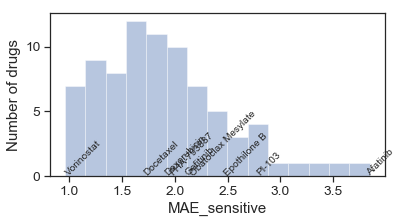

In [91]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(6,3))

score_name = 'MAE_sensitive'

sns.distplot(score_df[score_df['model']=='cadrres-wo-sample-bias-weight'][score_name], kde=False, bins=15)

score_model_df = score_df[score_df['model']=='cadrres-wo-sample-bias-weight']
selected_score_df = score_model_df.loc[score_model_df['drug_id'].isin(selected_drug_ids), ['drug_name', score_name]].sort_values(by=score_name)

for _, row in selected_score_df.iterrows():
    plt.text(row[score_name], 0, row['drug_name'], rotation=45, rotation_mode='anchor', fontsize=10)
    
plt.ylabel("Number of drugs")


Text(0, 0.5, 'Number of drugs')

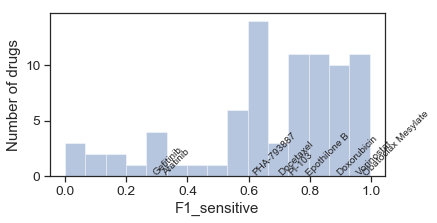

In [93]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(6,3))

score_name = 'F1_sensitive'

sns.distplot(score_df[score_df['model']=='cadrres-wo-sample-bias-weight'][score_name], kde=False, bins=15)

score_model_df = score_df[score_df['model']=='cadrres-wo-sample-bias-weight']
selected_score_df = score_model_df.loc[score_model_df['drug_id'].isin(selected_drug_ids), ['drug_name', score_name]].sort_values(by=score_name)

for _, row in selected_score_df.iterrows():
    plt.text(row[score_name], 0, row['drug_name'], rotation=45, rotation_mode='anchor', fontsize=10)
    
plt.ylabel("Number of drugs")


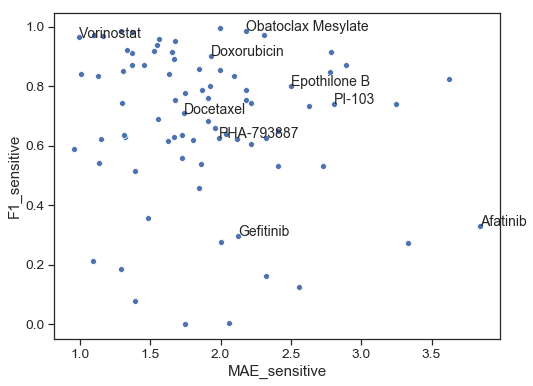

In [109]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=score_model_df, x='MAE_sensitive', y='F1_sensitive')

for _, row in score_model_df[score_model_df['drug_id'].isin(selected_drug_ids)].iterrows():
    plt.text(row['MAE_sensitive'], row['F1_sensitive'], row['drug_name'], rotation=0, rotation_mode='anchor', fontsize=14)

### For each cell line

In [ ]:
result_df_list = []

for model_spec_name in model_spec_name_list:
    for k in range(n_fold):
        
        pred_test_df = output_dict[model_spec_name][k]['pred_test_df'].T
        obs_test_df = output_dict[model_spec_name][k]['obs_test_df'].T
        
#         pred_train_df = output_dict[model_spec_name][k]['pred_train_df']
#         obs_train_df = output_dict[model_spec_name][k]['obs_train_df']
        
        cl_list = pred_test_df.columns
        
        results = []
        
        for u, c in enumerate(cl_list):
            
            x = obs_test_df[c].values
            y = pred_test_df[c].values
            sel = ~np.isnan(x)
            
            x = x[sel]
            y = y[sel]
            
            # spearman
            scor, pval = stats.spearmanr(x, y)
            
##### TODO #####
            
#             # F1 weighted
#             x_bool = (x < drug_log2_max_conc_dict[c]).astype(str)
#             y_bool = (y < drug_log2_max_conc_dict[c]).astype(str)
#             f1 = f1_score(x_bool, y_bool, average='weighted')
#             acc = accuracy_score(x_bool, y_bool)
            
#             precent_sensitive = (np.sum(x < drug_log2_max_conc_dict[d]) / len(x)) * 100
            
#             if precent_sensitive > 0:
#                 (f1_resistant, f1_sensitive) = f1_score(x_bool, y_bool, average=None)
#                 (precision1_resistant, precision_sensitive) = precision_score(x_bool, y_bool, average=None)
#             else:
#                 f1_resistant = np.nan
#                 f1_sensitive = np.nan
#                 precision1_resistant = np.nan
#                 precision_sensitive = np.nan
            
#             # MAE (sensitive)
#             sensitive_sel = x < drug_log2_max_conc_dict[d]
#             x_sensitive = x[sensitive_sel]
#             y_sensitive = y[sensitive_sel]
#             mae = np.mean(np.abs(x_sensitive - y_sensitive))

#             # MAE (capped)
#             x_capped = np.minimum(x, np.repeat(drug_log2_max_conc_dict[d], len(x)))
#             y_capped = np.minimum(y, np.repeat(drug_log2_max_conc_dict[d], len(y)))
#             capped_mae = np.mean(np.abs(x_capped - y_capped))
            
#             results += [[d, precent_sensitive, drug_log2_max_conc_dict[d], drug_log2_median_ic50_dict[d],
#                          scor, pval, acc, f1, f1_resistant, f1_sensitive, precision1_resistant, precision_sensitive, mae, capped_mae]]
            
#         result_df = pd.DataFrame(results, columns=['drug_id', 'precent_sensitive', 'log2_max_conc', 'log2_median_ic50', 'spearman', 'pval', 'accurary', 'F1_weighted', 'F1_resistant', 'F1_sensitive', 'precision1_resistant', 'precision_sensitive', 'MAE_sensitive', 'MAE_capped'])
#         result_df.loc[:, 'model'] = model_spec_name
#         result_df.loc[:, 'k'] = k+1
        
#         result_df_list.append(result_df)